<div class="alert alert-block alert-info">
    <b>Tip:</b> Use <b>%matplotlib widget</b> or <b>%matplotlib notebook</b> for interactive plots when notebook is running locally on your computer
</div>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CARDIAL-nyu/cmr-playground/blob/main/golden_angle_sample/Sample%20XD-GRASP%20Type%20Radial%20-%20Multi%20Coil.ipynb)

In [1]:
import sys
# interactive matplotlib doesn't work on google colab, so fall back to inline
if 'miniconda' not in sys.executable:
    %matplotlib inline
    !{sys.executable} -m pip install --force https://github.com/chengs/tqdm/archive/colab.zip
    !{sys.executable} -m pip install sigpy h5py tqdm
    ! git clone https://github.com/CARDIAL-nyu/cmr-playground
    %cd cmr-playground/golden_angle_sample
else:
    %matplotlib notebook

# Mult-Coil Example
In the previous `Sample XD-GRASP Type Radial - Single Coil` notebook, we assumed that we were imaging with a **single coil**, yielding a single matrix of k-space data.  Here, we use previously calculated coil sensitivities (via the ESPIRiT algorithm) in order to simulate an imaging process that produces multi-coil k-space data.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy as sp
import scipy.signal
import scipy.io
import seaborn as sns
import sigpy
import sigpy.plot
import sigpy.mri
import h5py
if 'miniconda' not in sys.executable:
    from tqdm import trange, tqdm
else:
    from tqdm.notebook import trange, tqdm

plt.style.use('fivethirtyeight')
five_thirty_eight = [
"#30a2da",
"#fc4f30",
"#e5ae38",
"#6d904f",
"#8b8b8b",
]
sns.set_palette(five_thirty_eight, color_codes=True)
sns.set_color_codes()

mpl.rcParams['axes.grid'] = False

# Load in a sample OCMR reconstruction (same as single coil notebook)

In [3]:
reconstructed_filename = 'output_slice1_us_0156_pt_1_5T_reshapeF_slice4.mat'
slice_mat = scipy.io.loadmat(reconstructed_filename)

In [4]:
# What's inside this container...
slice_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'xHat', 'pOut', 'xHat_abs_norm'])

### Dimensions (same as single coil notebook)
 - `n_ro`: number of samples in the readout direction
 - `n_pe`: number of phase-encoding lines
 - `n_frames`: number of frames in this cine

In [5]:
n_ro, n_pe, n_frames = slice_mat['xHat_abs_norm'].shape
n_ro, n_pe, n_frames

(352, 134, 30)

### Create a square frame (same as single coil notebook)
 - for ease, let's deal with square images by zero-filling the borders
 - let's also just use the 1st frame of this cine that has 30 frames

In [6]:
selected_frame = 0 # let's work with just the 1st frame of the cine
square_cine = np.zeros((n_ro, n_ro))
square_cine[:,(n_ro-n_pe)//2:-(n_ro-n_pe)//2] = slice_mat['xHat_abs_norm'][...,selected_frame]
square_cine.shape

(352, 352)

### Visualize the frame we're dealing with (same as single coil notebook)

<IPython.core.display.Javascript object>


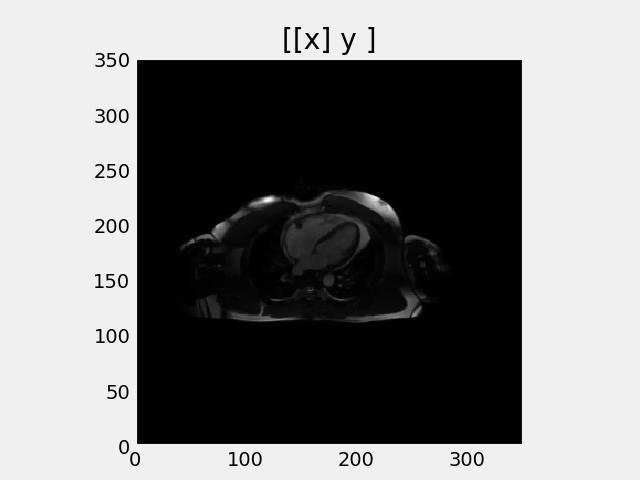

In [7]:
sigpy.plot.ImagePlot(square_cine, x=0, y=1)

# Read in the coil sensitivity maps (new)
 - different than the previous notebook, we now will load in coil sensitivity maps that will allow us to take one image and turn it into a multi-coil image from which we can then derive multi-coil k-space data

In [8]:
ocmr_id = reconstructed_filename.split('_reshape')[0].replace('output_slice1_','')
a_coil_sense_map = scipy.io.loadmat(f'espirit_{ocmr_id}.mat')['espirit_map']

n_coils_sense, n_ro_sense, n_pe_sense = a_coil_sense_map.shape

square_sense_map = np.zeros((n_coils_sense, n_ro_sense, n_ro_sense), dtype=complex)
square_sense_map[:, :,(n_ro_sense-n_pe_sense)//2:-(n_ro_sense-n_pe_sense)//2] = a_coil_sense_map

n_coils_sense, n_ro_sense, n_pe_sense, square_sense_map.shape

(20, 352, 126, (20, 352, 352))

# Visualize coil sensitivity maps (new)
 - each coil is located at a slightly different location on the patient
 - the bright regions show where the coils are most sensitive to (generally the area of the body closest to the coil)

<IPython.core.display.Javascript object>


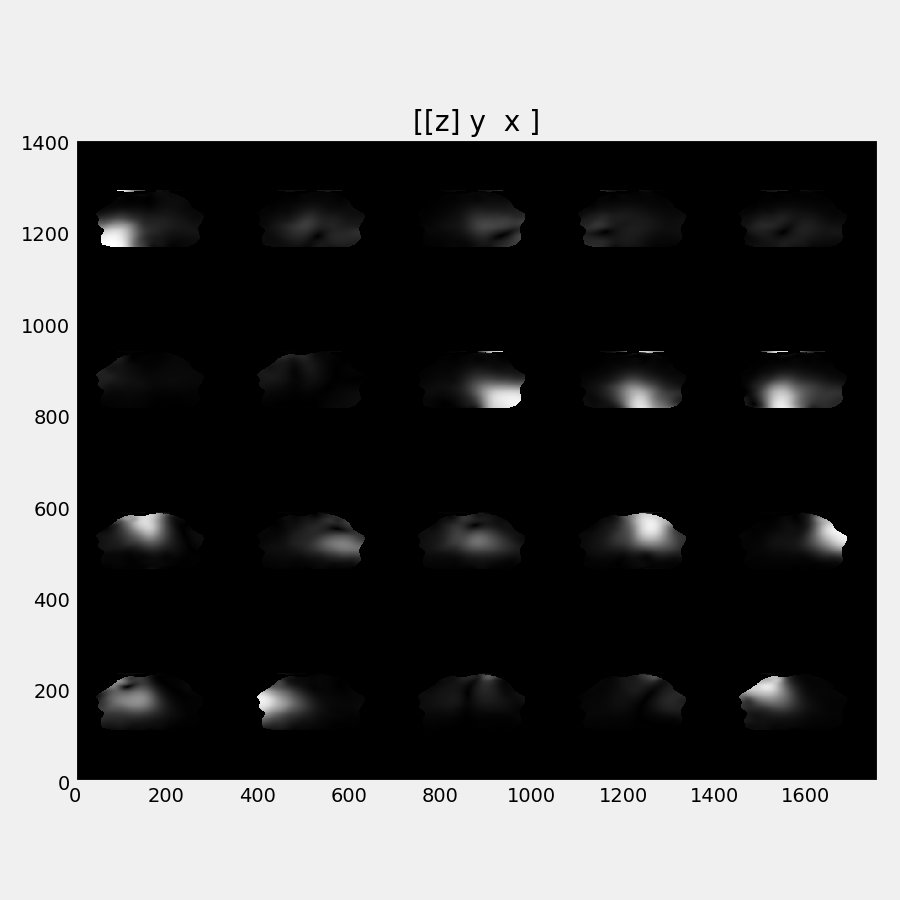

In [9]:
i_coil_maps = sigpy.plot.ImagePlot(square_sense_map.transpose((0,2,1)), z=0) # transpose so the body is horizontal

i_coil_maps.fig.set_figwidth(9)
i_coil_maps.fig.set_figheight(9)

i_coil_maps.fig.tight_layout()

# Helper functions (same as single coil notebook)
 - `return_ga_traj` returns the tiny golden angle kspace trajectory

In [10]:
def return_ga_traj(nX, ntviews, tiny_num=7):
    """Returns tiny golden angle trajectory and density compensation

    Parameters
    ----------
    nX : int
        number of readout points
    ntviews : int
        number of radial spokes/turns
    tiny_num : int
        type of golden angle, e.g. 7 for 7th tiny golden angle

    Returns
    -------
    traj : ndarray
        trajectory with shape (nX, ntviews)
    densitycomp : ndarray

    Reference
    ---------
    https://doi.org/10.1002/mrm.25831

    """
    golden_ratio = (np.sqrt(5.0) + 1.0) / 2.0
    golden_angle = np.pi / (golden_ratio + tiny_num - 1)

    radian = np.mod(np.arange(0, ntviews) * golden_angle, 2. * np.pi)
    rho = np.arange(-np.floor(nX / 2), np.floor(nX / 2)) + 0.5

    _sin = np.sin(radian)
    _cos = np.cos(radian)

    # Complex trajectory
    traj = np.stack(((rho[..., np.newaxis] * _sin[np.newaxis, ...]),
                     (rho[..., np.newaxis] * _cos[np.newaxis, ...])), axis=2)
    
    # Density Compensation
    densitycomp = np.sqrt(np.power(traj[...,0], 2) + np.power(traj[...,1], 2))
    densitycomp /= densitycomp.max()
    
    # Reshape into (n_spokes, n_readout, 2)
    traj = traj.transpose((1,0,2))
    
    # Reshape into (n_spokes, n_readout)
    densitycomp = densitycomp.transpose((1,0))
    
    return traj, densitycomp

### Create a radial trajectory based off of the nyquist rate (same as single coil notebook)
 - nyquist criteria for radial trajectories is $\frac{\textrm{N}\pi}{2}$, where $\textrm{N}$ is the number of lines required for fully-sampled data in cartesian sampling.  In this case, it is equal to `n_ro`.

# Quick Aside (new)

### Image from sequentially acquired radial spokes

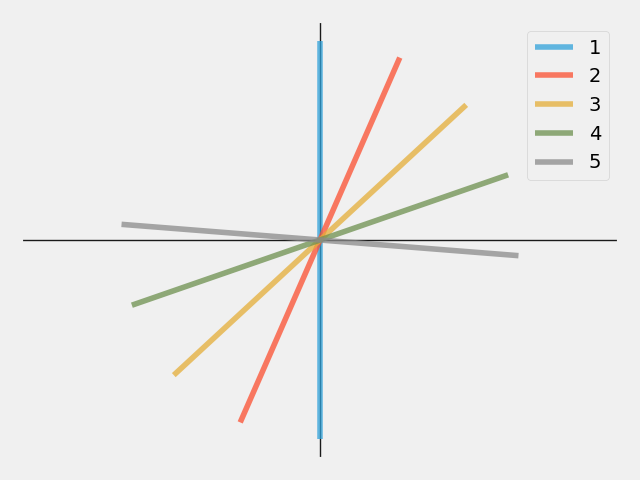

 - if one single frame of the cine was acquired with sequentially incremented radial spokes in k-space, the 1st 5 radial spokes for that frame might something look like this figure-- the 1st acquired spoke is blue, ..., the 5th acquired spoke is the gray.
   - for a fully sampled frame that is 320x320, we might have $\frac{\textrm{320}\pi}{2} \approx 502$ total number of spokes, but here only the first 5 is shown for clarity of how each sucessive spoke follows the previous spoke by a constant angular increment.
 - **important to note:** each spoke follows the next by the same angular increment

### Reality for retrospectively gated CMR: spokes can clump in certain regions

<img src=" 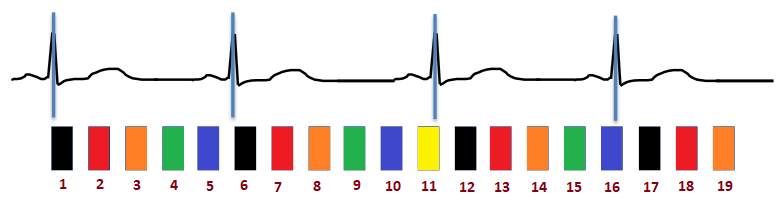" />


 - in reality, we typically cannot acquire all k-space data for a particular cardiac frame in the cine all at once because the heart is constantly moving.  instead, we continuously record a stream of k-space data across a number of heart beats, (say 4 heart beats as shown in the image with the EKG tracing above)
   - we can then use the EKG to **sort** the stream of k-space data so that when we form an image of a particular time in the cardiac cycle, it uses k-space data acquired at approximately the same cardiac state.
       - note that if we didn't do any type of sorting and just took all the sets of k-space data (numbered 1 through 19) to form an image, each spoke would be uniformly distributed. however,doing this would create a very blurry image because each spoke was taken at different cardiac states; this would be like a taking a photograph with low shutter speed of someone doing a very quick dance --the photo would be blurry.
   - **sort** means that we can take the continous stream of radial spokes acquired across the 5 heart beats and group them together according to how far into a cardiac cycle it was when they were acquired.
   - for instance, if we want to reconstruct a frame that represents the heart at the beginning of systole (i.e. a heart that is about to eject), we can look at an EKG recording across the 4 heart beats, figure out the time difference between when that line of k-space was measured relative to the most recent R wave of the QRS complexes, and group them according to this time difference. Examples:
       - For an image in early-systole, we can perhaps group all the black k-space data (#1, #6, #12, #17) together to create one frame of the heart in early systole.
       - For an image in mid-diastole, we can group all the orange k-space data (#3, #8, #14, #19) together to create another frame of the heart in mid-diastole
 - from this sorting procedeure, all k-space spokes that are stitched together to form one frame are no longer separated by a constant angular increment, but instead can potentially be clumped up in some quadrants and sparse in another quadrant. an example of the 1st 5 spokes after this sorting process might look something like the figure below.

<img src=" 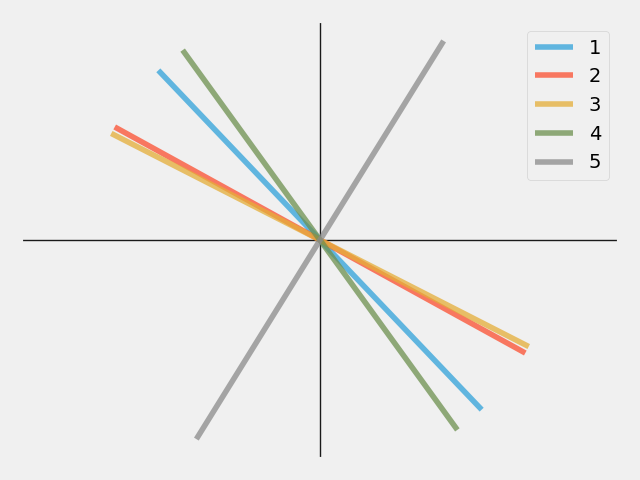" />

 - **note:** some spokes are very close together, others are pretty far from the clump.
 - this more irregular pattern of spokes adds a little more complexity to the reconstruction process
 - if we consider that each frame of a cine has different irregular patterns of sampling, this **incoherence** feature can be used to our advantage in compressed sensing type reconstructions, because aliasing artifacts due to undersampling will be more diffuse across the image.
   - then if each frame of a cine has non-identical aliasing artifacts, they can be jointly used to "fill in the gaps" wherein one region of a frame may be contaminated by aliasing, but in other frames, this same region appears essentially alias-free.

## Let's try to simulate irregularly spaced radial spokes

**Step 1.** we will use `return_ga_traj()` to simulate some large number of radial spokes that were acquired sequentially in time, say `55,000` spokes.

**Step 2.** for this first simple demonstration, we will assume that each frame of the cine will contain the same number of radial spokes, e.g. `50` spokes for each frame.  since we have a sequence of `55,000` spokes, we can randomly sample, without replacement, `50` spokes from the `55,000`.  this will result in each frame having `50` radial spokes that may be irregularly spaced and clumpy.
 - if each frame would require ~`500` spokes to be considered fully-sampled, this would mean that with only `50` spokes per frame, we've done a 10x undersampling.

### Step 1.

In [11]:
# 1. we will use return_ga_traj() to simulate some large number of radial spokes that were 
#    acquired sequentially in time, say 55,000 spokes.
traj, dc = return_ga_traj(nX=n_ro, ntviews=55000)

ntviews = traj.shape[0]

n_ro, traj.shape, dc.shape

(352, (55000, 352, 2), (55000, 352))

### Step 2.

In [12]:
np.random.seed(20211110)

num_spokes_per_frame = 50

- we will now randomly sample 50 spokes for each of the 30 frames of the cine
- below, we will get a list of 30 sets of 50 indices that we can use to pull out those spokes from the trajectory calculated in **Step 1.**

In [13]:
spoke_indices = np.random.choice(traj.shape[0], (n_frames, num_spokes_per_frame), replace=False)
spoke_indices.shape

(30, 50)

 - let's visualize the first 10 spokes of each frame of the cine to verify they have irregular spacing patterns

<IPython.core.display.Javascript object>


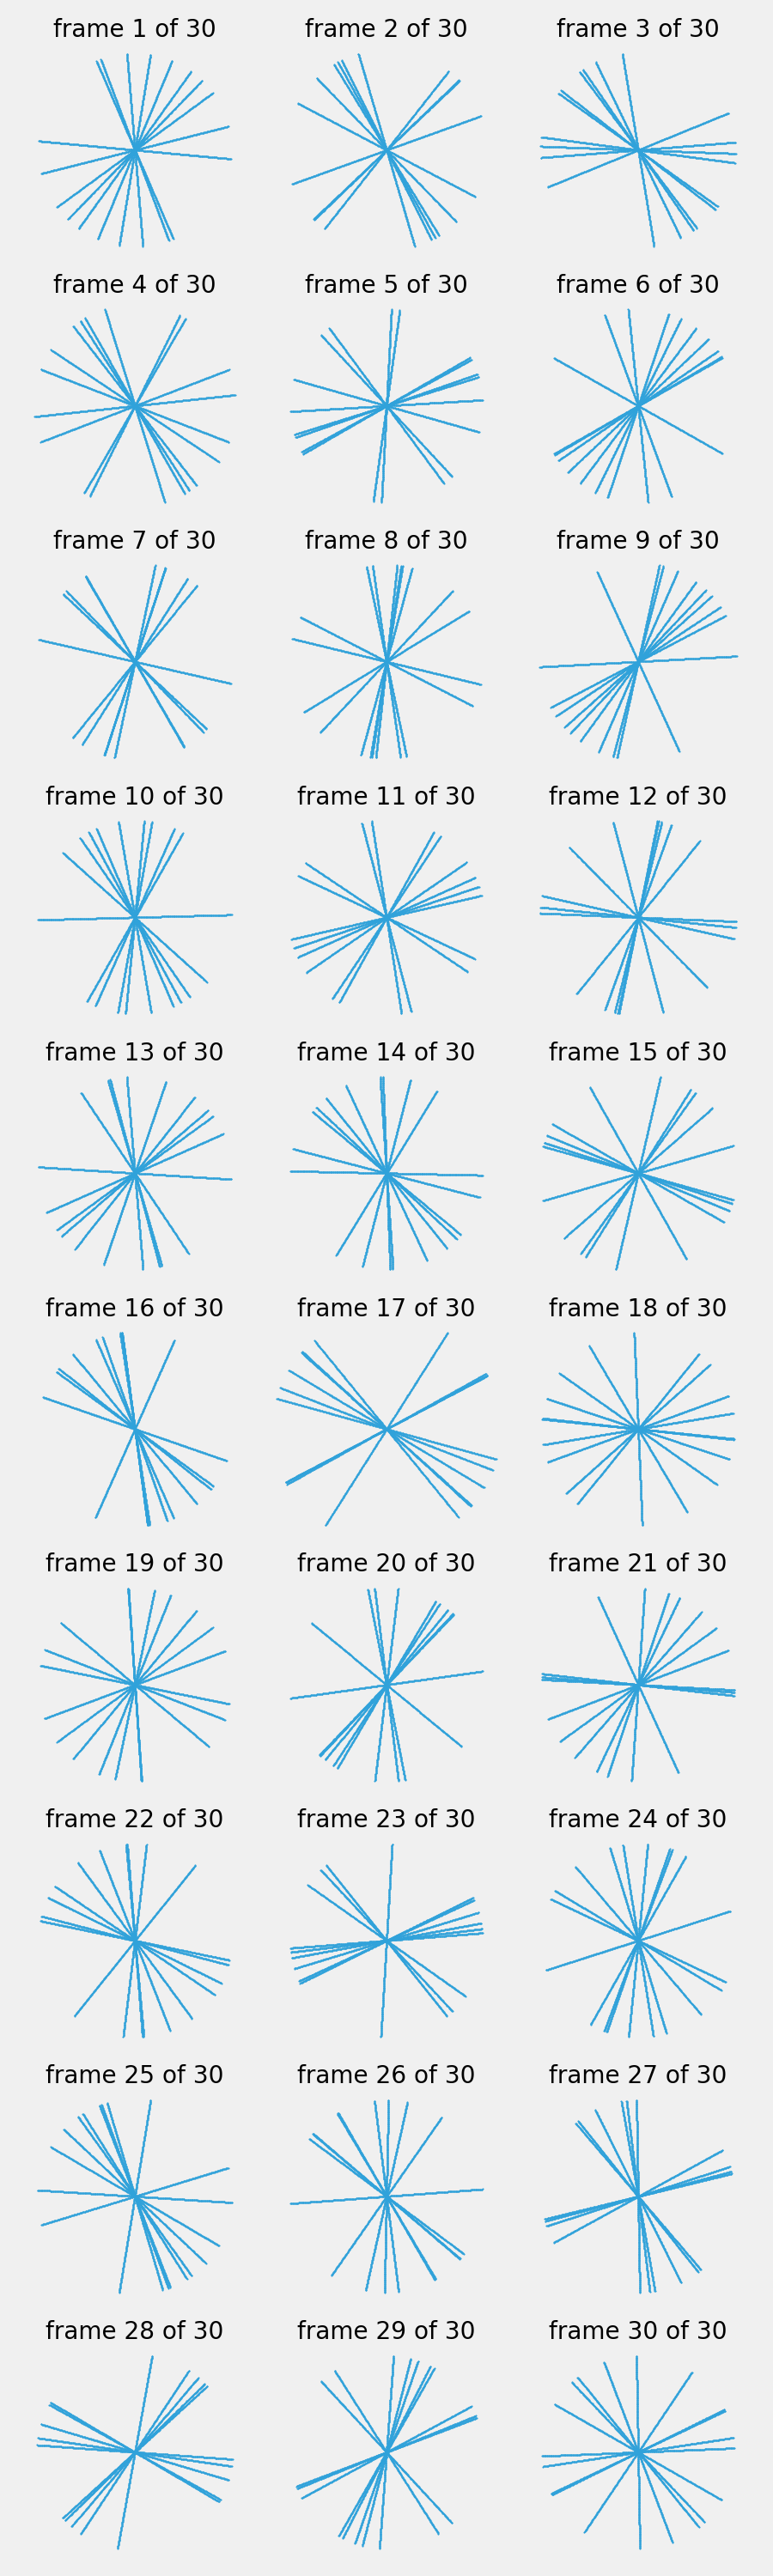

0it [00:00, ?it/s]

In [14]:
num_spokes_to_plot = 10

f_sk, ax_sk = plt.subplots(nrows=10, ncols=3, figsize=(9, 30))

for a_frame, an_ax in tqdm(enumerate(ax_sk.ravel())):
    traj_random = traj[spoke_indices[a_frame,:],:,:]
    an_ax.scatter(traj_random[:num_spokes_to_plot,:,0], traj_random[:num_spokes_to_plot,:,1], s=1)
    an_ax.set_title(f'frame {a_frame+1} of 30')
    an_ax.axis('equal')
    an_ax.set_xticks([])
    an_ax.set_yticks([])
    
    
f_sk.tight_layout()

Great!  Now we've created a set of radial spokes for each frame of the cine --30 sets of 100 irregularly spaced spokes for the 30 frames of the cine.

With those sets of irregularly spaced spokes, we are now ready to create the multi-coil non-cartesian k-space data.

# Use the SENSE linear operator to produce multi-coil non-cartesian k-space data
 - this essentially produces data from each of the various spatial perspectives corresponding coil element locations.

In [15]:
# When coordinates are passed to Sense(), it will use an NUFFT internally to give us multi-coil **non-cartesian** kspace data
S_nc = sigpy.mri.linop.Sense(mps=square_sense_map, coord=traj_random)

S_nc

<[20, 50, 352]x[352, 352]> Sense Linop>

In [16]:
# Multi-coil non-cartesian kspace
ksp_mc_nc = S_nc*square_cine

ksp_mc_nc.shape

(20, 50, 352)

Great!  Now `ksp_mc_nc` contains the multi-coil **non-cartesian** kspace data for the 1st frame of the cine

The shape of `ksp_mc_nc.shape` = `(20, 50, 352)` means that we have 20 coils and for each coil, we have 50 spokes that contain 352 data points per spoke.

# Let's visualize the multi-coil images reconstructed from the non-cartesian kspace data
 - we will need NUFFT to deal with non-cartesian kspace data

In [17]:
# Create the NUFFT operator and its adjoint

# NUFFT transforms from image space to non-cartesian k-space
NUFFT = sigpy.linop.NUFFT(ishape=S_nc.oshape, coord=traj_random)

# adjoint NUFFT transforms from non-cartesian k-space to image space
NUFFT_H = sigpy.linop.NUFFTAdjoint(oshape=square_sense_map.shape, coord=traj_random)

In [18]:
# a density compensation operator is available in SigPy
p = sigpy.mri.pipe_menon_dcf(coord=traj_random)

print(p.shape)

PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

(50, 352)


# Let's see what the multi-coil images look like with standard density compensation

<IPython.core.display.Javascript object>


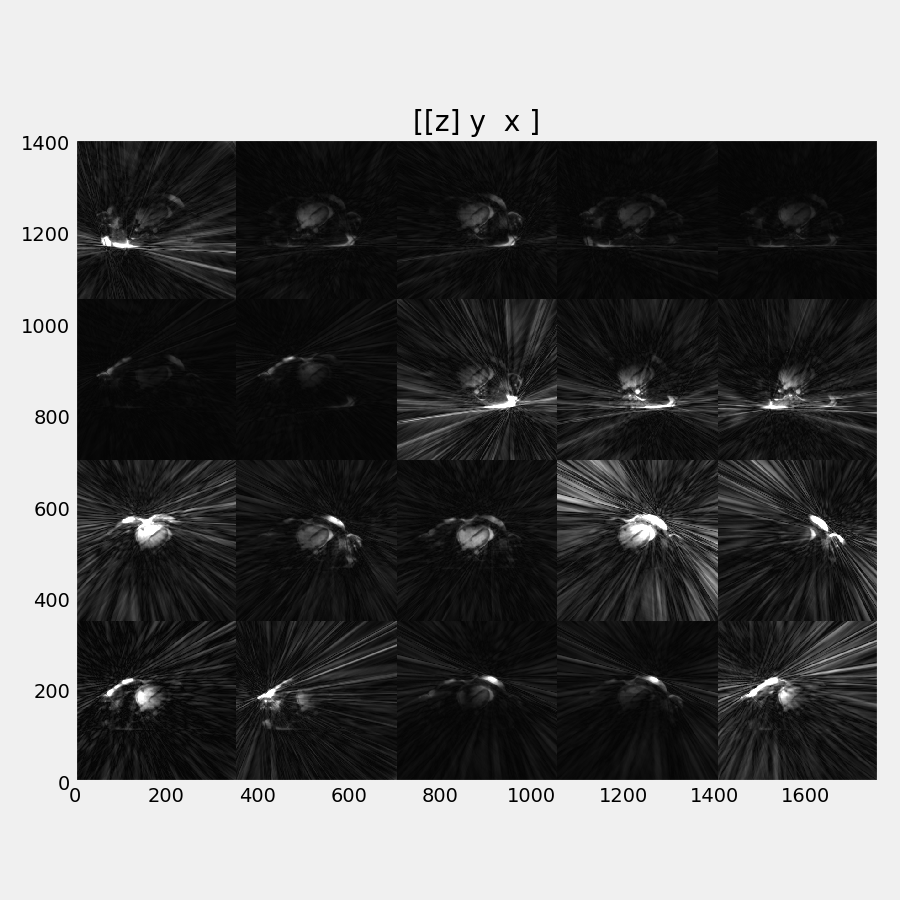

In [19]:
# Apply the SENSE and adjoin NUFFT operators to produce the coil images
coil_images = NUFFT_H*(ksp_mc_nc*p)

# arrange in coils, y, x
coil_images = coil_images.transpose((0,2,1))
i_coil_images = sigpy.plot.ImagePlot(coil_images, z=0)

i_coil_images.fig.set_figwidth(9)
i_coil_images.fig.set_figheight(9)

i_coil_images.fig.tight_layout()

# better contrast/brightness found from keyboard shortcuts [, ], {, and }
# if in interactive matplotlib, you can hit the h key to bring up the shortcuts menu
i_coil_images.vmin, i_coil_images.vmax = (-1.710023072015672e-14, 8.668780368371318e-13)
i_coil_images.update_image()

### Get the Sum of Squares combination of the coil images

<IPython.core.display.Javascript object>


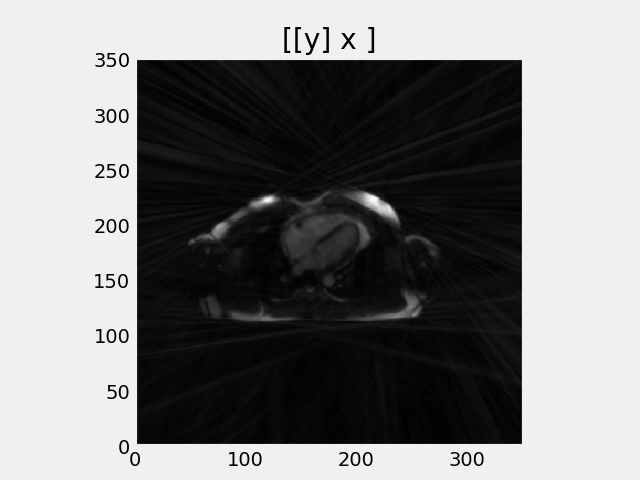

In [20]:
# mode='l' will plot the log of the image so that we can better see the streaking artifacts typical of images
#  reconstructed from radial trajectories
sos_plot = sigpy.plot.ImagePlot(np.sqrt(np.sum(np.abs(coil_images)**2, axis=0)), mode='m')

# sos_plot.vmin, sos_plot.vmax = (0.055106184353822474, 0.839890577722372)
# sos_plot.update_image()

# Remarks
 - note that images reconstructed from non-cartesian k-space data have streaking artifacts which becomes more prominent with greater degrees of undersampling
   - try increasing `num_spokes_per_frame` to `100` to see how the SoS image becomes clearer with less streaking
   - increase `num_spokes_per_frame` to `500` to see how a fully-sampled radial trajectory image looks like
 - this demo worked with only the first frame of the cine (see `selected_frame = 0` towards the beginning of this notebook)
   - try with the other 29 frames of the cine
 - an additional complexity we have with real data is that each frame of the cine may have very different number of spokes and therefore be undersampled to varying degrees.
   - for instance, the 1st frame of the cine (early systole) may have 100 spokes, but the 2nd frame may have only 60 frames, while the last frame of the cine may have 270 spokes.